In [1]:
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime


In [2]:
now_date = datetime.now().strftime("%d.%m.%Y")

# Get data
alerts_url = f'https://www.oref.org.il//Shared/Ajax/GetAlarmsHistory.aspx?lang=he&fromDate=01.01.2014&toDate={now_date}&mode=0'
alerts_json = requests.get(alerts_url).json()

# Break multi-region alerts into separate records
df = pd.DataFrame.from_records(alerts_json)
df['data'] = df['data'].str.split(',')
df = df.explode('data')

# Remove sub-regions such as א, ב, ג, ד
df = df[df['data'].str.len() > 2]

# Change Hatzor to detailed name as the google geocoder fail to detect the correct city
df['data'] = df['data'].replace('חצור', 'חצור אשדוד')

# Show rocket sirens only
df = df[df['category_desc'] == 'ירי רקטות וטילים']
# df.to_csv('RocketLaunchData.csv', encoding='utf-8-sig', index=False)

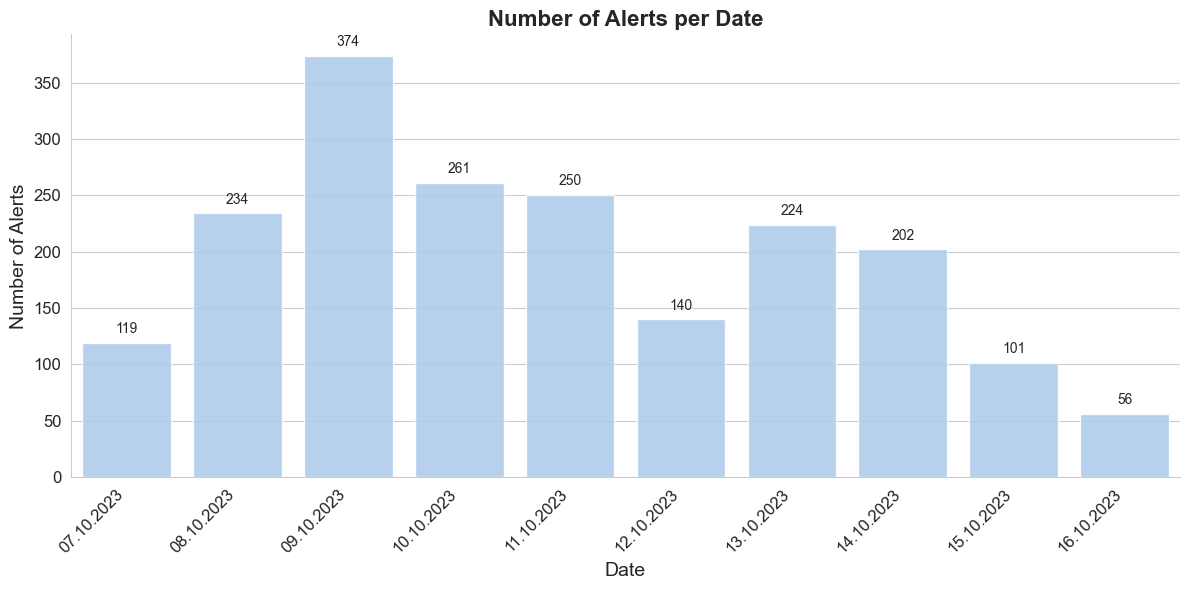

In [3]:
alerts_per_date = df['date'].value_counts()

# Sort the series by date
alerts_per_date = alerts_per_date.sort_index()

# Set a visually pleasing color palette and style
sns.set_palette("pastel")
sns.set_style("whitegrid")

# Create a bar plot with Seaborn
plt.figure(figsize=(12, 6))  # Adjusted figure size for better visualization
bar_plot = sns.barplot(x=alerts_per_date.index, y=alerts_per_date.values, alpha=0.85)

# Set the title and labels with modified font sizes for clarity
plt.title('Number of Alerts per Date', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Alerts', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels
plt.yticks(fontsize=12)

for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 10), 
                     textcoords='offset points', 
                     fontsize=10)

sns.despine()
plt.tight_layout()

plt.show()

In [4]:
# Extract the hour from the time column with the specified format
df['hour'] = pd.to_datetime(df['time'], format="%H:%M:%S").dt.hour

# Count the occurrences of each hour
hourly_counts = df['hour'].value_counts()

# Ensure all 24 hours are represented
all_hours = pd.Series(range(24))
hourly_counts = hourly_counts.reindex(all_hours, fill_value=555)


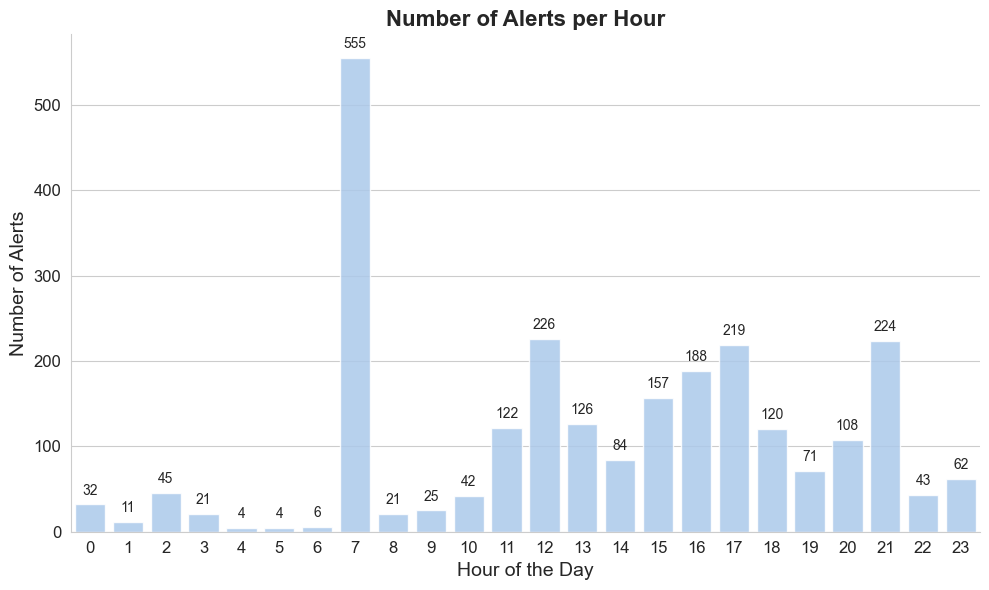

In [5]:
# Set a more visually pleasing color palette
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create a bar plot with Seaborn
plt.figure(figsize=(10, 6))  # Set a larger figure size
bar_plot = sns.barplot(x=hourly_counts.index, y=hourly_counts.values, alpha=0.85)

# Set the title and labels with larger fonts for clarity
plt.title('Number of Alerts per Hour', fontsize=16, fontweight='bold')
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Number of Alerts', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Annotate each bar with the respective value
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 10), 
                     textcoords='offset points', 
                     fontsize=10)

sns.despine()  # Remove the top and right spines
plt.tight_layout()

plt.show()

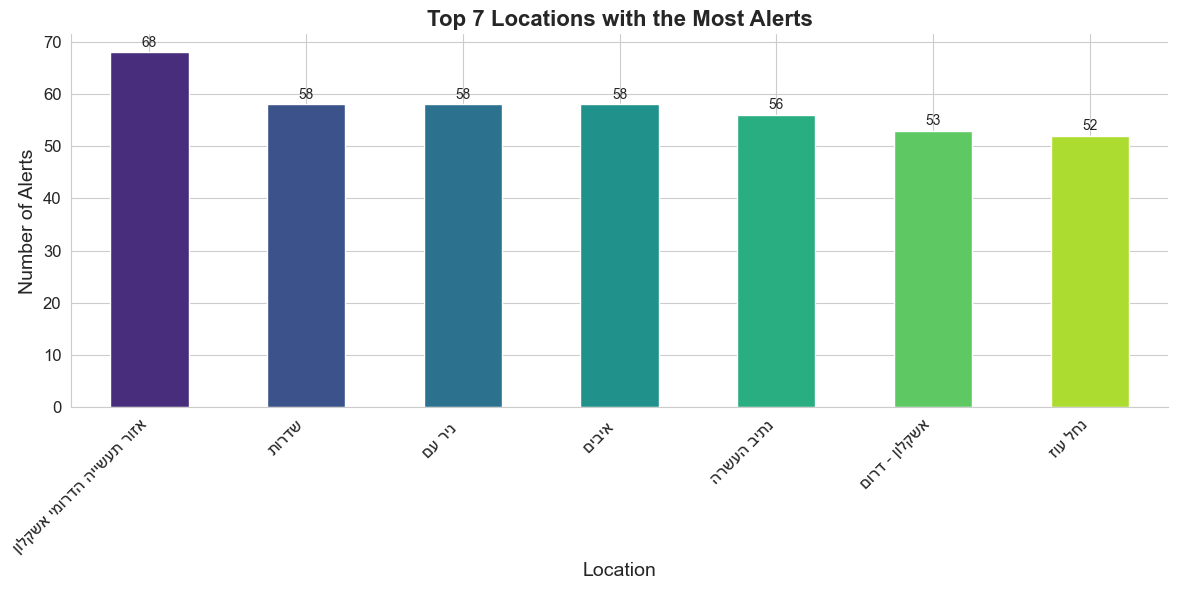

In [6]:
# Count the frequency for each location and select the top 5
location_counts = df['data'].value_counts().head(7)

# Reverse the strings for proper Hebrew display
location_counts.index = [name[::-1] for name in location_counts.index]

# Set style
sns.set_style('whitegrid')

# Create the bar plot
location_counts.plot(kind='bar', figsize=(12, 6), color=sns.color_palette("viridis", len(location_counts)))

# Add the title and labels
plt.title('Top 7 Locations with the Most Alerts', fontsize=16, fontweight='bold')
plt.xlabel('Location', fontsize=14)
plt.ylabel('Number of Alerts', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Remove the top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add annotations to each bar
for index, value in enumerate(location_counts):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

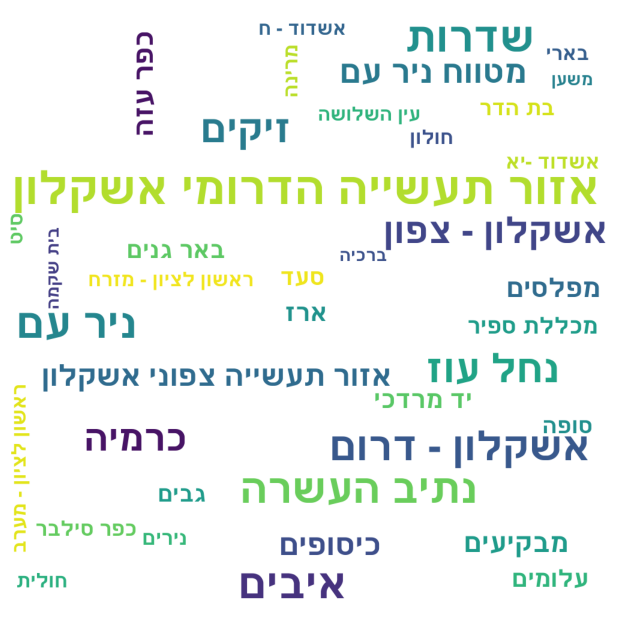

In [7]:
# Counting frequency
city_freq = df['data'].value_counts()[:40]

# Reverse the city names for Hebrew
city_freq.index = [city[::-1] for city in city_freq.index]

# Generate Word Cloud
wordcloud = WordCloud(width = 1000, height = 1000,  # Increased canvas size
                      background_color ='white',  # Neutral background color
                      colormap="viridis",  # Using a colormap
                      font_path='./FreeSansBold.ttf',
                      stopwords = set(),
                      max_font_size=150,  # Limiting maximum font size
                      min_font_size = 10).generate_from_frequencies(city_freq)

plt.figure(figsize = (6, 6), facecolor = None)  # Increased figsize for better clarity
plt.imshow(wordcloud) 
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

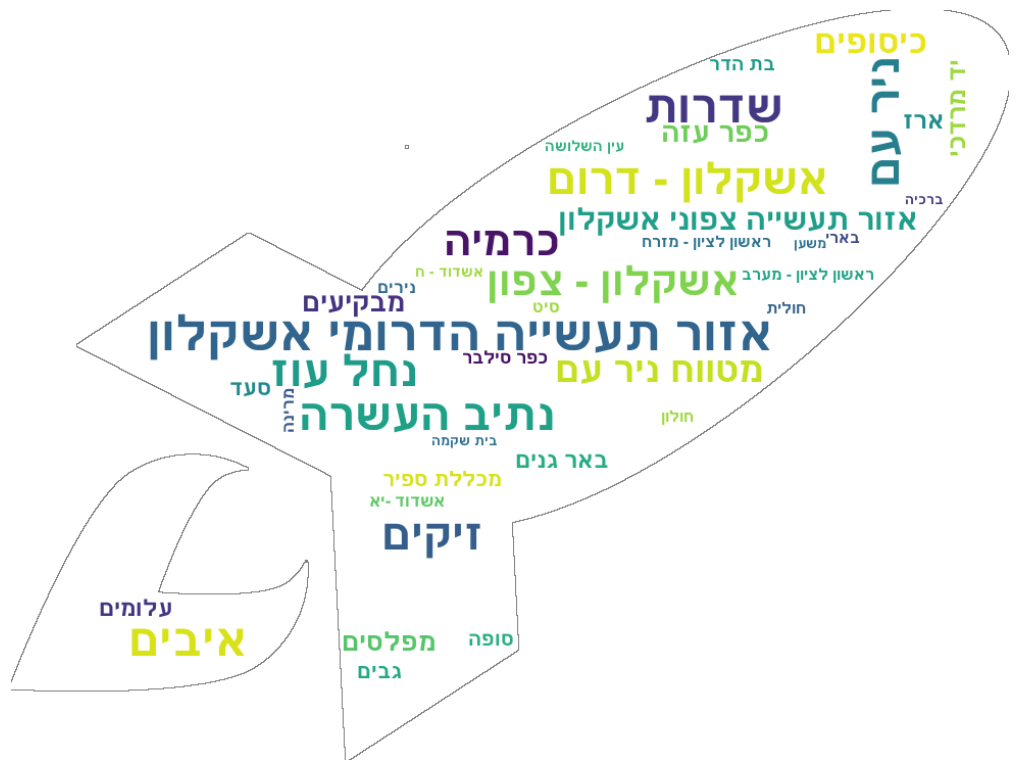

In [8]:
rocket_image = np.array(Image.open('./rocket.png'))
# Ensure that the rocket image is of 3 channels
if len(rocket_image.shape) == 2:
    rocket_image = np.stack([rocket_image] * 3, axis=-1)

# Create a mask: Non-zero values will be used for drawing words
mask = rocket_image.copy()
mask[mask.sum(axis=2) == 0] = 255

# Generate Word Cloud
wordcloud = WordCloud(
    mask=mask,
    background_color='white',
    contour_width=1,
    contour_color='gray',
    font_path='./FreeSansBold.ttf',  # You need  a font that supports Hebrew characters
    min_font_size=10
).generate_from_frequencies(city_freq)

image_colors = ImageColorGenerator(rocket_image, default_color=(255, 255, 255))

# Display the word cloud using colors from the rocket image
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud.recolor(), interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()